In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
import numpy as np
import pandas as pd
import tqdm
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import string
import re
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import collections
import random
import os
import time
import json
from PIL import Image
import zipfile


## Utility Functions to Load and clean data

In [35]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
	  file = open(filename, 'r')
	  # read all text
	  text = file.read()
	  # close the file
	  file.close()
	  return text

# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

## Data Loading and Preprocessing

In [36]:
kagglePath = "/content/kaggle.json"
f = open(kagglePath,'r')
data = json.load(f)
f.close()
os.environ['KAGGLE_USERNAME'] = data['username']
os.environ['KAGGLE_KEY'] = data['key'] 

In [37]:
! pwd
% cd /content/drive/MyDrive/Datasets/Flickr 8k
! pwd
! kaggle datasets download -d adityajn105/flickr8k 

/content
/content/drive/MyDrive/Datasets/Flickr 8k
/content/drive/MyDrive/Datasets/Flickr 8k
 99% 1.03G/1.04G [00:06<00:00, 168MB/s]
100% 1.04G/1.04G [00:06<00:00, 167MB/s]


In [41]:
% cd ..

/content


In [42]:
zipRep = zipfile.ZipFile("/content/drive/MyDrive/Datasets/Flickr 8k/flickr8k.zip")
zipRep.extractall("/content")
zipRep.close()

In [43]:
image_dir = "/content/Images"
images = os.listdir(image_dir)

desc_dir = "/content/captions.txt"
print("The number of jpg flies in Flicker8k: {}".format(len(images)))

The number of jpg flies in Flicker8k: 8091


In [44]:
text = load_doc(desc_dir)
print(text[:325])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playho


In [64]:
def make_dataset(text):
  """Making Dataframe from text"""
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split(',')
      if splitted[0] == 'image':
        continue
      if len(splitted) == 1:
        continue
      df.append(["/content/Images/" + splitted[0]] + [splitted[1].lower()])
  return df

In [65]:
df = make_dataset(text)

len(df)

40455

In [66]:
df[:10]

[['/content/Images/1000268201_693b08cb0e.jpg',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['/content/Images/1000268201_693b08cb0e.jpg',
  'a girl going into a wooden building .'],
 ['/content/Images/1000268201_693b08cb0e.jpg',
  'a little girl climbing into a wooden playhouse .'],
 ['/content/Images/1000268201_693b08cb0e.jpg',
  'a little girl climbing the stairs to her playhouse .'],
 ['/content/Images/1000268201_693b08cb0e.jpg',
  'a little girl in a pink dress going into a wooden cabin .'],
 ['/content/Images/1001773457_577c3a7d70.jpg',
  'a black dog and a spotted dog are fighting'],
 ['/content/Images/1001773457_577c3a7d70.jpg',
  'a black dog and a tri-colored dog playing with each other on the road .'],
 ['/content/Images/1001773457_577c3a7d70.jpg',
  'a black dog and a white dog with brown spots are staring at each other in the street .'],
 ['/content/Images/1001773457_577c3a7d70.jpg',
  'two dogs of different breeds looking at each other on

In [67]:
data = pd.DataFrame(df,columns=["filename", "caption"])
data.head()

,filename,caption
0,/content/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,/content/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,/content/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,/content/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,/content/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [68]:
data.to_csv('/content/drive/MyDrive/Datasets/Flickr 8k/flickr_8k_data.csv')

In [69]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Flickr 8k/flickr_8k_data.csv')
data.head()

,Unnamed: 0,filename,caption
0,0,/content/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,/content/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,/content/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,/content/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,/content/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [70]:
data.iloc[0, 1]

'/content/Images/1000268201_693b08cb0e.jpg'

In [71]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [72]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
  print("We can see that all the keys are having values count = 5")
  print(ct_dict)

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

In [73]:
unique_filenames = utility_counter(data)

The number of unique file names : 8091
We can see that all the keys are having values count = 5
Counter({'/content/Images/1000268201_693b08cb0e.jpg': 5, '/content/Images/1001773457_577c3a7d70.jpg': 5, '/content/Images/1002674143_1b742ab4b8.jpg': 5, '/content/Images/1003163366_44323f5815.jpg': 5, '/content/Images/1007129816_e794419615.jpg': 5, '/content/Images/1007320043_627395c3d8.jpg': 5, '/content/Images/1009434119_febe49276a.jpg': 5, '/content/Images/1012212859_01547e3f17.jpg': 5, '/content/Images/1015118661_980735411b.jpg': 5, '/content/Images/1015584366_dfcec3c85a.jpg': 5, '/content/Images/101654506_8eb26cfb60.jpg': 5, '/content/Images/101669240_b2d3e7f17b.jpg': 5, '/content/Images/1016887272_03199f49c4.jpg': 5, '/content/Images/1019077836_6fc9b15408.jpg': 5, '/content/Images/1019604187_d087bf9a5f.jpg': 5, '/content/Images/1020651753_06077ec457.jpg': 5, '/content/Images/1022454332_6af2c1449a.jpg': 5, '/content/Images/1022454428_b6b660a67b.jpg': 5, '/content/Images/1022975728_75515

## Visualizing Image along with Captions

In [74]:
def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for jpgfnm in unique_filenames[40:45]:
      # filename = image_dir + '/' + jpgfnm
      captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
      image_load = load_img(jpgfnm, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

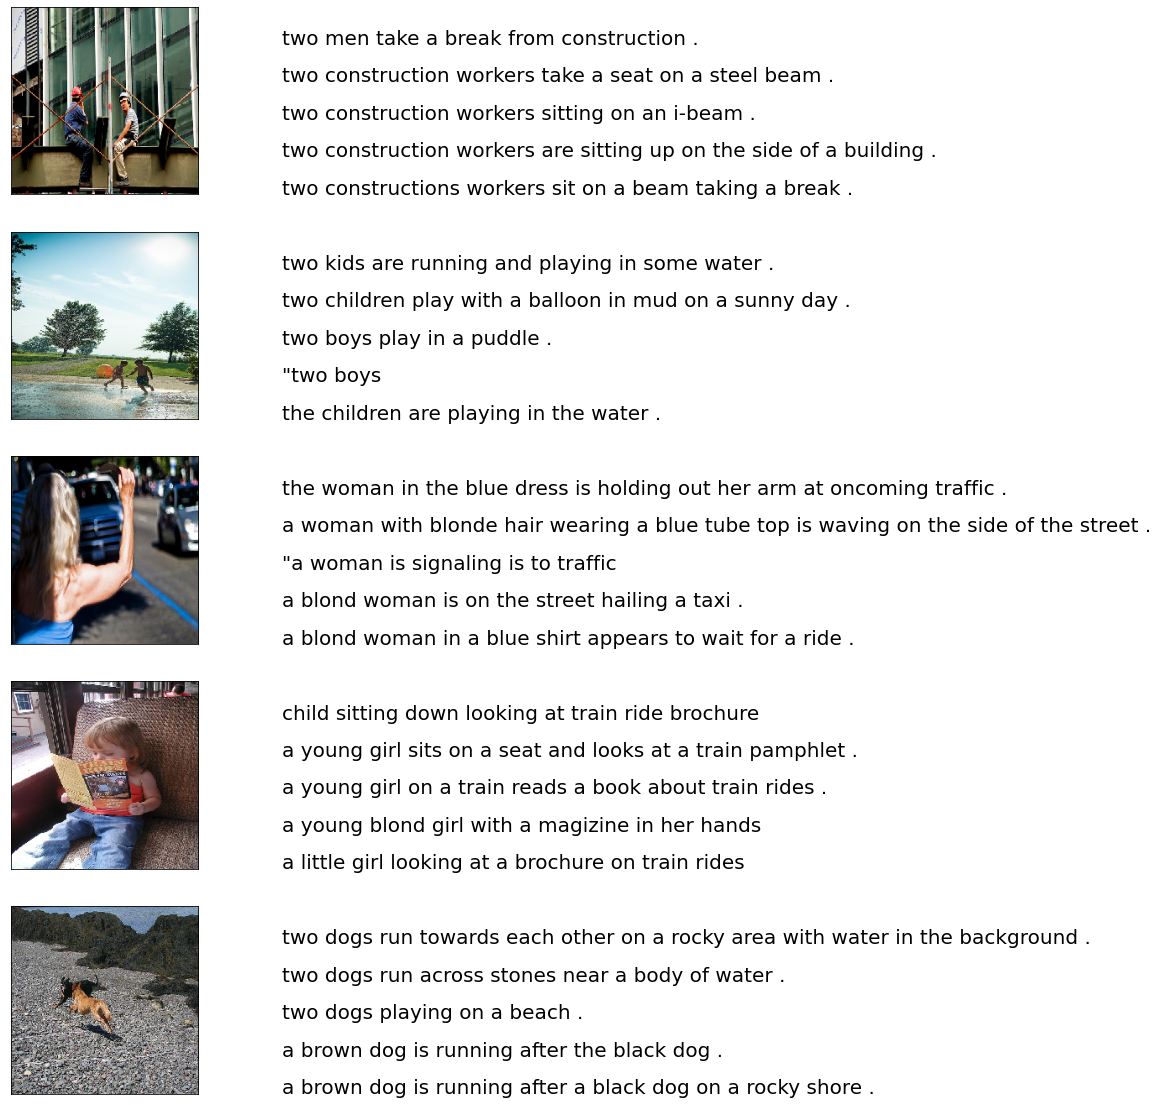

In [75]:
image_desc_plotter(data)

## Preprocessing the captions

In [76]:
data.head()

,filename,caption
0,/content/Images/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,/content/Images/1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,/content/Images/1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,/content/Images/1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,/content/Images/1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [77]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for i in range(len(data)):
  caption = f"<start> {data.iloc[i, 1]} <end>"
  image_path = data.iloc[i, 0]
  image_path_to_caption[image_path].append(caption)

print(len(image_path_to_caption))

8091


In [78]:
image_path_to_caption

defaultdict(list,
            {'/content/Images/1000268201_693b08cb0e.jpg': ['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
              '<start> a girl going into a wooden building . <end>',
              '<start> a little girl climbing into a wooden playhouse . <end>',
              '<start> a little girl climbing the stairs to her playhouse . <end>',
              '<start> a little girl in a pink dress going into a wooden cabin . <end>'],
             '/content/Images/1001773457_577c3a7d70.jpg': ['<start> a black dog and a spotted dog are fighting <end>',
              '<start> a black dog and a tri-colored dog playing with each other on the road . <end>',
              '<start> a black dog and a white dog with brown spots are staring at each other in the street . <end>',
              '<start> two dogs of different breeds looking at each other on the road . <end>',
              '<start> two dogs on pavement moving toward each other . <en

### Selecting Training Set

In [79]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 7000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 35,000 examples.
train_image_paths = image_paths[:7000]
print(len(train_image_paths))

7000


In [80]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a girl about to eat watermelon and drink juice . <end>


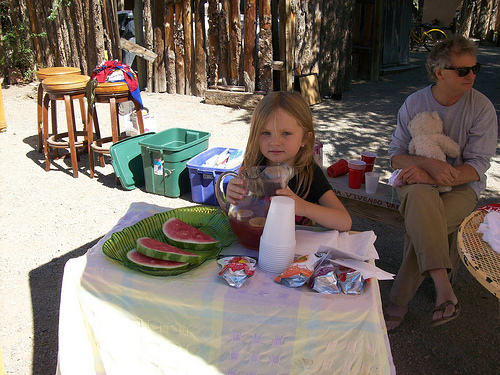

In [81]:
t = 20
print(train_captions[t])
Image.open(img_name_vector[t])

## Preprocess Images for Decoder (InceptionV3)
We will use InceptionV3 trained on Imagenet to classify the images. We will extract the features from the last convolutional layer.

Preprocess steps to match input of InceptionV3:
- Resize images to 299x299
- Normalize the images to lie in [-1, 1] range.

In [82]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialize the model and load weights

In [83]:
image_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [84]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Caching Image Features
We will cache the features extracted by the InceptionV3 into disk in .npy format

In [85]:
from tqdm import tqdm  # To see a progress bar

# Get unique images
encode_train = sorted(set(img_name_vector))

# We can change the batch size according to our need
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 219/219 [01:38<00:00,  2.22it/s]


## Preprocess and Tokenize the Captions
We will do the following tasks:
- Create a vocabulary of unique words in the data
- We will limit the vocab size to 8000 and replace all other words with token "UNK" (unknown).
- Then we will create word-index and then pad the sequences.

In [86]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [87]:
# Choose the top 8000 words from the vocabulary
NUM_WORDS = 8000
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [88]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [89]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# Pad each vector to the max_length of the captions
cap_vector = pad_sequences(train_seqs, maxlen = max_length, padding='post')

## Splitting into Train and Val Sets

In [91]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [92]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(28000, 28000, 7000, 7000)

In [93]:
len(img_name_vector), len(cap_vector)

(35000, 35000)

## Creating Dataset for the model from the data

In [117]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = NUM_WORDS + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [118]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [119]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating and Combining all the Models
- We extract the features from the lower convolutional layer of InceptionV3 which gives a vector of shape (8, 8, 2048).
- Reshaping them to (64, 2048)
- This vector is then passed to the CNN Encoder.
- Then the GRU is used to predict the captions from the images.


We will be using the Local Attention method for the Decoder

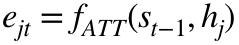

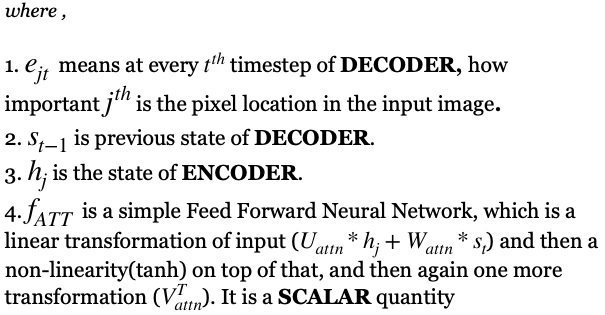

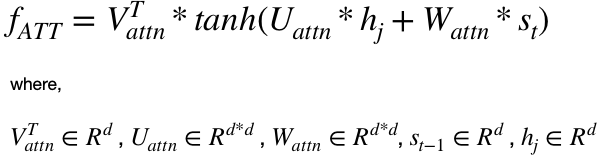

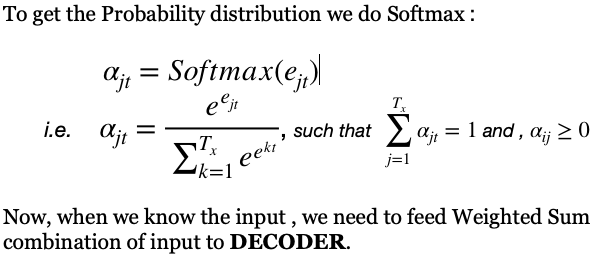

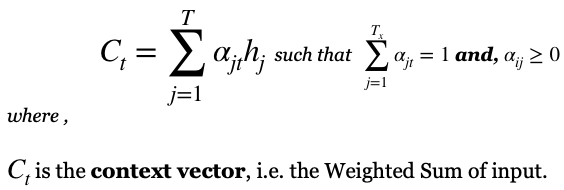

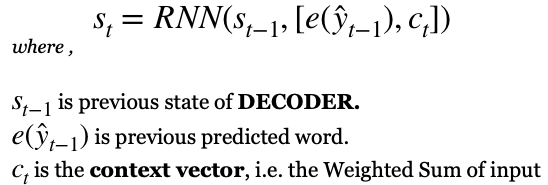

In [120]:
class LocalAttention(Model):
  def __init__(self, units):
    super(LocalAttention, self).__init__()
    self.w1 = tf.keras.layers.Dense(units)
    self.w2 = tf.keras.layers.Dense(units)
    self.v = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    """
    features: CNN Encoder output, shape = (batch_size, 64, emb_dim)
    hidden: shape = (batch_size, hidden_size)
    """
    hidden_with_time = tf.expand_dims(hidden, 1)  # shape: (batch_size, 1, hidden_size)
    attention_hidden_layer = (tf.nn.tanh(self.w1(features) + self.w2(hidden_with_time)))  # shape: (batch_size, 64, units)
    score = self.v(attention_hidden_layer)  # shape: (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)  # shape: (batch_size, 64, 1)
    context_vector = attention_weights * features  
    context_vector = tf.reduce_sum(context_vector, axis=1)  # After reduce_sum, shape: (batch_size, hidden_size)

    return context_vector, attention_weights

In [121]:
class CNNEncoder(Model):
  # Since we have already extracted the features and dumped it
  # This encoder passes those features through a Fully connected layer
  def __init__(self, emb_dim):
    super(CNNEncoder, self).__init__()
    self.fc = tf.keras.layers.Dense(emb_dim)  # shape: (batch_size, 64, embedding_dim)

  def call(self, x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [122]:
class GRUDecoder(Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(GRUDecoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = LocalAttention(self.units)

  def call(self, x, features, hidden):
    # Defining attention as a seperate model
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)  # shape: (batch_size, 1, embedding_dim + hidden_size)
    output, state = self.gru(x)
    x = self.fc1(output)  # shape: (batch_size, max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))  # shape: (batch_size * max_length, hidden_size)
    x = self.fc2(x)  # shape: (batch_size * max_length, vocab)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [123]:
encoder = CNNEncoder(embedding_dim)
decoder = GRUDecoder(embedding_dim, units, vocab_size)

In [124]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoint

In [127]:
checkpoint_path = "/content/drive/MyDrive/Datasets/Flickr 8k/checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [128]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training the Model

In [129]:
loss_plot = []

In [130]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 5

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
encoder.save_weights('CNNEncoder_weights.h5')
decoder.save_weights('GRUDecoder_weights.h5')

In [159]:
encoder.load_weights('CNNEncoder_weights.h5')
decoder.load_weights('GRUDecoder_weights.h5')

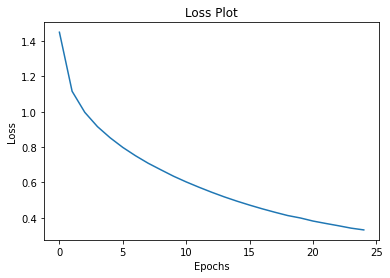

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Evaluating the Model with BLEU Score
- The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
- It stops predicting when the model predicts the end token.
- After predicting the caption, we calculate the BLEU Score to check the output performance

In [134]:
def evaluate(image):  # Using Random Search
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)  # Sentences start token
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])  # Store the predicted word

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [135]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

BLEU score: 0.27952792741962756
Real Caption: the woman is sitting in the boat being rowed by the man
Prediction Caption: a coming woman front in people


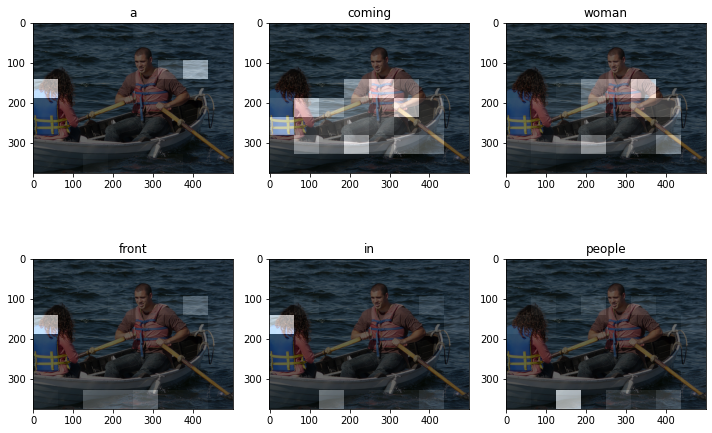

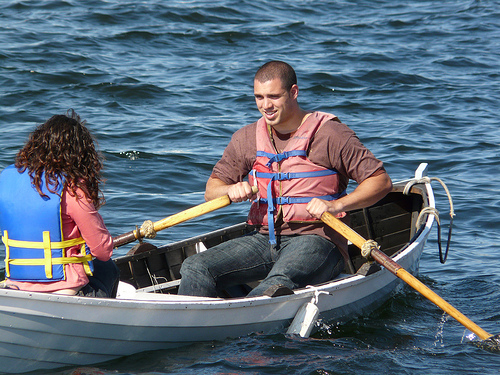

In [183]:
# Caption generation on a random validation image
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
# print(cap_val[rid])
reference = [[tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]]]
reference[0].remove('<start>')
reference[0].remove('<end>')
real_caption = ' '.join(reference[0])
result, attention_plot = evaluate(image)
if '<end>' in result:
  result.remove('<end>')

# Calculating the BLEU Score
score = sentence_bleu(reference, result)
print(f"BLEU score: {score}")

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))

plot_attention(image, result, attention_plot)
Image.open(image)

#### Calculating Average BLEU Score for the Validation Set

In [184]:
total_bleu_score = []
sentences = []

start = time.time()
for i in tqdm(range(len(img_name_val))):
  image = img_name_val[i]
  reference = [tokenizer.index_word[j] for j in cap_val[i] if j not in [0]]
  reference.remove('<start>')
  reference.remove('<end>')
  result, attention_plot = evaluate(image)
  if '<end>' in result:
    result.remove('<end>')
  sentences.append(reference)

  # Calculating the BLEU Score
  if (i+1)%5 == 0:
    score = sentence_bleu(sentences, result)
    total_bleu_score.append(score)
    sentences = []
  if i%700 == 0 and i!=0:
    print(f'{i} images done! {len(img_name_val)-i} more to go. Time elapsed: {time.time()-start:.2f} sec\n')


 10%|█         | 702/7000 [02:46<22:28,  4.67it/s]

700 images done! 6300 more to go. Time elapsed: 166.34 sec



 20%|██        | 1401/7000 [05:29<18:36,  5.01it/s]

1400 images done! 5600 more to go. Time elapsed: 329.05 sec



 30%|███       | 2102/7000 [08:10<13:37,  5.99it/s]

2100 images done! 4900 more to go. Time elapsed: 490.54 sec



 40%|████      | 2802/7000 [10:49<16:48,  4.16it/s]

2800 images done! 4200 more to go. Time elapsed: 649.62 sec



 50%|█████     | 3501/7000 [13:33<12:13,  4.77it/s]

3500 images done! 3500 more to go. Time elapsed: 813.21 sec



 60%|██████    | 4201/7000 [16:16<11:37,  4.01it/s]

4200 images done! 2800 more to go. Time elapsed: 976.80 sec



 70%|███████   | 4902/7000 [18:59<07:35,  4.60it/s]

4900 images done! 2100 more to go. Time elapsed: 1139.07 sec



 80%|████████  | 5602/7000 [21:43<05:29,  4.24it/s]

5600 images done! 1400 more to go. Time elapsed: 1303.32 sec



 90%|█████████ | 6302/7000 [24:27<03:12,  3.62it/s]

6300 images done! 700 more to go. Time elapsed: 1466.86 sec



100%|██████████| 7000/7000 [27:07<00:00,  4.30it/s]


In [187]:
print(f"Average BLEU Score on the validation set of {len(img_name_val)} val images: {sum(total_bleu_score)/len(total_bleu_score): .8f}")

Average BLEU Score on the validation set of 7000 val images:  0.50994458


In [188]:
len(total_bleu_score)

1400